In addition to the other sources (Uniprot, official Website), there is another Uniprot annotation file from EBI. Are there any differences? Is the EBI file better than the other options?

According to the comments in the file, it is generated by Uniprot, and contains annotations for all proteins in Uniprot! This file could contain the qualifiers and evidence codes we have been missing from the Uniprot custom download file. 

## TODO:

- Analyze file
- Filter down
    - Molecular function
    - enables
- Compare to other GO datasets
    - GO annotation from Uniprot custom download
    - Uniprot annotation from GO website
        - IEA, non-IEA
- Write script for filtering file, and saving it as xz

In [1]:
# !This file contains all GO annotations and gene product information for proteins in the UniProt KnowledgeBase (UniProtKB),
# !ComplexPortal protein complexes, and RNAcentral identifiers.
# !
# !date-generated: 2022-11-17 13:42
# !generated-by: UniProt
# !go-version: http://purl.obolibrary.org/obo/go/releases/2022-11-12/extensions/go-plus.owl
# !


In [2]:
import pandas as pd

TODO remove drop_dupl, sort_values after command has finished

In [75]:
from subpred.dataset import create_dataset
df_uniprot = create_dataset(
    input_file="../data/raw/uniprot/uniprot_2022_05_evidence1-2_nofragments.tsv",
    # keywords_classes = None,
    # keywords_classes_all = SUBSTRATE_KEYWORDS,
    # keywords_filter = None,
    multi_substrate="keep",
    # outliers=outliers,
    verbose=True,
    # tax_ids_filter=[3702, 9606, 83333, 559292],
    sequence_clustering=70,
    evidence_code=2,
    invalid_amino_acids="remove_amino_acids",
    # gene_names_only = True,
    # force_update=True,
    # remove_sequence_fragments = True,
    # force_update = False,
    tcdb_substrates_file="../data/raw/tcdb/tcdb_substrates.tsv",
    swissprot_only=False,
)

from subpred.util import pickle_read

df_go_ebi = pickle_read(
    "../data/raw/gene_ontology/goa_uniprot_all_ebi_filtered.tsv.xz",
    header=None,
    names=["Uniprot", "qualifier", "go_id", "evidence_code", "aspect", "date"],
)
df_go_ebi_filtered = df_go_ebi[df_go_ebi.Uniprot.isin(df_uniprot.index)]
df_go_ebi_filtered = df_go_ebi_filtered[df_go_ebi_filtered.qualifier == "enables"]
df_go_ebi_filtered = df_go_ebi_filtered[df_go_ebi_filtered.evidence_code != "IEA"]

Found pickle, reading...
cd-hit: clustered .......... sequences into finished clusters at threshold 70


## Filtering GO-EBI file for proteins in Uniprot

reading pickle ../data/raw/gene_ontology/goa_uniprot_all_ebi_filtered.tsv.xz.1676900041.184084.pkl...


What is the difference between the two?

In [76]:
df_go_ebi_filtered = df_go_ebi[df_go_ebi.Uniprot.isin(df_uniprot.index)]

<AxesSubplot:>

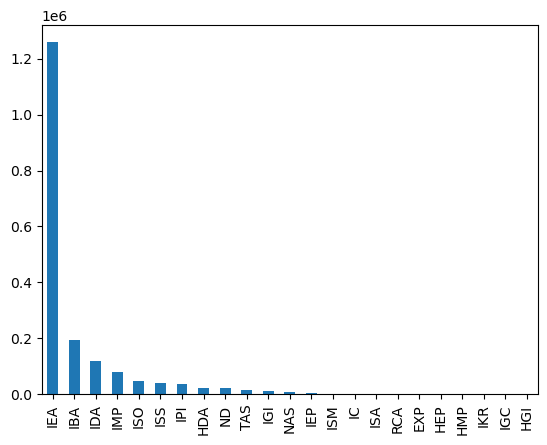

In [77]:
df_go_ebi_filtered.evidence_code.value_counts(dropna=False).plot.bar()

<AxesSubplot:>

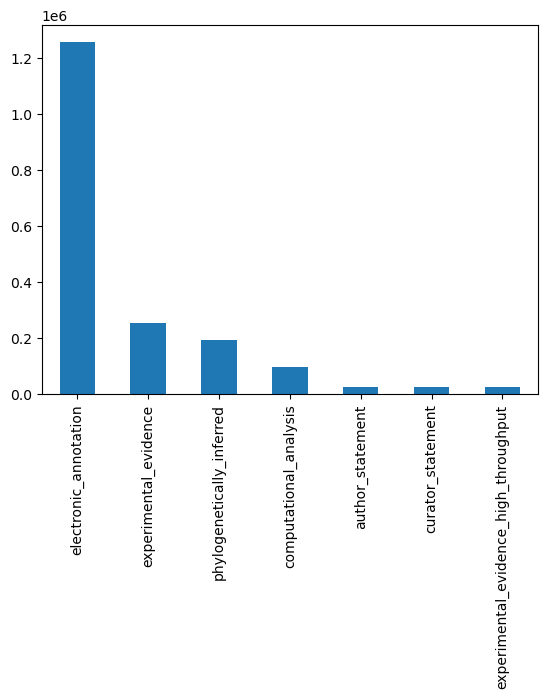

In [78]:
df_go_ebi_filtered.evidence_code.map(EVIDENCE_CODE_TO_DESCRIPTION).value_counts(dropna=False).plot.bar()

In [79]:
df_go_ebi_filtered.qualifier.value_counts(dropna=False)

enables                                           719997
involved_in                                       633696
located_in                                        371624
is_active_in                                       61363
part_of                                            55987
acts_upstream_of_or_within                         28160
contributes_to                                      3084
colocalizes_with                                    1530
NOT|enables                                         1034
NOT|involved_in                                      894
acts_upstream_of                                     638
NOT|located_in                                       374
acts_upstream_of_or_within_positive_effect           105
acts_upstream_of_positive_effect                      85
acts_upstream_of_negative_effect                      44
NOT|is_active_in                                      40
NOT|acts_upstream_of_or_within                        28
acts_upstream_of_or_within_nega

## Left-Merging Uniprot GO annotations with qualifers, evidence codes etc.

In [ ]:
from subpred.go_utils import  GeneOntology, GO_FILE, EVIDENCE_CODE_TO_DESCRIPTION

go = GeneOntology(GO_FILE) 

In [ ]:
# df_go_ebi
from subpred.dataset import get_go_df

df_uniprot_go = get_go_df(df_uniprot, go)

In [12]:
df_uniprot_go_merged = df_uniprot_go.merge(df_go_ebi, how="left", on=["Uniprot", "go_id"])

<AxesSubplot:>

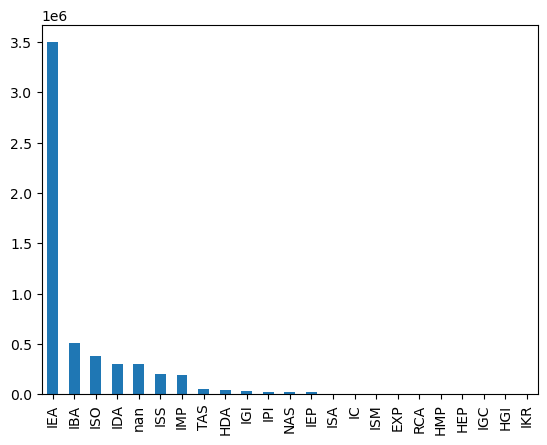

In [13]:
df_uniprot_go_merged.evidence_code.value_counts(dropna=False).plot.bar()

<AxesSubplot:>

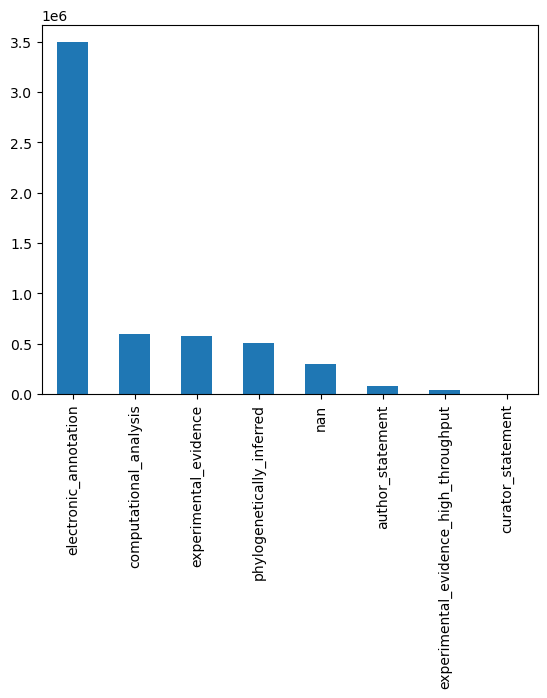

In [14]:
df_uniprot_go_merged.evidence_code.map(EVIDENCE_CODE_TO_DESCRIPTION).value_counts(dropna=False).plot.bar()

In [15]:
df_uniprot_go_merged.qualifier.value_counts(dropna=False)

involved_in                                   1847509
enables                                       1799711
located_in                                    1233726
NaN                                            303991
part_of                                        194438
is_active_in                                   140690
acts_upstream_of_or_within                      78032
acts_upstream_of                                 3927
contributes_to                                   3146
colocalizes_with                                 2169
NOT|involved_in                                   526
NOT|enables                                       475
NOT|located_in                                    342
acts_upstream_of_positive_effect                  237
acts_upstream_of_or_within_positive_effect        229
acts_upstream_of_negative_effect                  122
acts_upstream_of_or_within_negative_effect         72
NOT|acts_upstream_of_or_within                     41
NOT|part_of                 

### Comparison in terms of transmembrane transporter annotations

In [30]:
import numpy as np
def get_label(go_id):
    try:
        return go.get_label(go_id)
    except AttributeError:
        return np.nan

In [31]:
labels = {go_id : get_label(go_id) for go_id in df_go_ebi_filtered.go_id.dropna().unique()}

labels

{'GO:0000166': 'nucleotide binding',
 'GO:0005524': 'ATP binding',
 'GO:0051082': 'unfolded protein binding',
 'GO:0140662': 'ATP-dependent protein folding chaperone',
 'GO:0006457': 'protein folding',
 'GO:0004176': 'ATP-dependent peptidase activity',
 'GO:0004252': 'serine-type endopeptidase activity',
 'GO:0008233': 'peptidase activity',
 'GO:0008236': 'serine-type peptidase activity',
 'GO:0016787': 'hydrolase activity',
 'GO:0016887': 'ATP hydrolysis activity',
 'GO:0043565': 'sequence-specific DNA binding',
 'GO:0006508': 'proteolysis',
 'GO:0006515': 'protein quality control for misfolded or incompletely synthesized proteins',
 'GO:0030163': 'protein catabolic process',
 'GO:0034605': 'cellular response to heat',
 'GO:0005737': 'cytoplasm',
 'GO:0003723': 'RNA binding',
 'GO:0003735': 'structural constituent of ribosome',
 'GO:0019843': 'rRNA binding',
 'GO:0006412': 'translation',
 'GO:0005840': 'ribosome',
 'GO:0015934': 'large ribosomal subunit',
 'GO:1990904': 'ribonucleopro

In [33]:
df_go_ebi_filtered = df_go_ebi_filtered.assign(go_term = df_go_ebi_filtered.go_id.map(labels))

In [41]:
df_go_ebi_filtered = df_go_ebi_filtered[~df_go_ebi_filtered.go_term.isnull()]

In [44]:
df_go_ebi_filtered.isnull().any(axis=None)

False

In [58]:
df_go_ebi_filtered = df_go_ebi_filtered[
    ["Uniprot", "go_id", "go_term", "qualifier", "evidence_code", "aspect", "date"]
]


Which columns contain null?

In [53]:
for col_name in df_uniprot_go_merged.columns:
    print(col_name, df_uniprot_go_merged[col_name].isnull().any())
    


Uniprot False
go_id False
go_term False
qualifier False
evidence_code False
aspect False
date False


In [52]:
for col_name in df_uniprot_go_merged.columns:
    print(col_name, df_uniprot_go_merged[col_name].isnull().any())
    df_uniprot_go_merged = df_uniprot_go_merged[~df_uniprot_go_merged[col_name].isnull()]

Uniprot False
go_id False
go_term False
qualifier True
evidence_code False
aspect False
date False


In [63]:
df_uniprot_go_merged

,Uniprot,go_id,go_term,qualifier,evidence_code,aspect,date
0,A0A0C5B5G6,GO:0001649,osteoblast differentiation,involved_in,IDA,P,20210329.0
1,A0A0C5B5G6,GO:0003677,DNA binding,enables,IDA,F,20210329.0
2,A0A0C5B5G6,GO:0003677,DNA binding,enables,IEA,F,20230125.0
3,A0A0C5B5G6,GO:0005615,extracellular space,located_in,IDA,C,20160223.0
4,A0A0C5B5G6,GO:0005634,nucleus,located_in,IDA,C,20210329.0
...,...,...,...,...,...,...,...
5609409,X5MFI4,GO:0016757,glycosyltransferase activity,enables,IEA,F,20230125.0
5609410,X5MI49,GO:0000139,Golgi membrane,located_in,IEA,C,20230125.0
5609411,X5MI49,GO:0016757,glycosyltransferase activity,enables,IEA,F,20230125.0
5609412,X5MPI5,GO:0000139,Golgi membrane,located_in,IEA,C,20230125.0


Finding differences between DFs:

In [64]:
df_uniprot_go_merged.duplicated().any()

False

In [62]:
df_go_ebi_filtered.duplicated().any()

False

In [66]:
df_combined = pd.concat([df_uniprot_go_merged, df_go_ebi_filtered], axis=0).reset_index(drop=True)

In [69]:
intersection = df_combined.duplicated(keep=False)

In [70]:
df_combined[~intersection]

,Uniprot,go_id,go_term,qualifier,evidence_code,aspect,date
5305423,A0A009FND8,GO:0000166,nucleotide binding,enables,IEA,F,20230125.0
5305427,A0A009FND8,GO:0006457,protein folding,involved_in,IEA,P,20230125.0
5305428,A0A009FS68,GO:0000166,nucleotide binding,enables,IEA,F,20230125.0
5305432,A0A009FS68,GO:0008233,peptidase activity,enables,IEA,F,20230125.0
5305433,A0A009FS68,GO:0008236,serine-type peptidase activity,enables,IEA,F,20230125.0
...,...,...,...,...,...,...,...
12885600,Z9JJ69,GO:0030163,protein catabolic process,involved_in,IEA,P,20230125.0
12885603,Z9JMY9,GO:0000166,nucleotide binding,enables,IEA,F,20230125.0
12885607,Z9JMY9,GO:0006457,protein folding,involved_in,IEA,P,20230125.0
12885608,Z9JND5,GO:0000166,nucleotide binding,enables,IEA,F,20230125.0


In [73]:
df_go_ebi_filtered[df_go_ebi_filtered.Uniprot == "A0A009FND8"]

,Uniprot,go_id,go_term,qualifier,evidence_code,aspect,date
8052,A0A009FND8,GO:0000166,nucleotide binding,enables,IEA,F,20230125
8053,A0A009FND8,GO:0005524,ATP binding,enables,IEA,F,20230125
8054,A0A009FND8,GO:0051082,unfolded protein binding,enables,IEA,F,20230125
8055,A0A009FND8,GO:0140662,ATP-dependent protein folding chaperone,enables,IEA,F,20230125
8056,A0A009FND8,GO:0006457,protein folding,involved_in,IEA,P,20230125


In [72]:
df_uniprot_go_merged[df_uniprot_go_merged.Uniprot == "A0A009FND8"]

,Uniprot,go_id,go_term,qualifier,evidence_code,aspect,date
4125798,A0A009FND8,GO:0005524,ATP binding,enables,IEA,F,20230125.0
4125799,A0A009FND8,GO:0051082,unfolded protein binding,enables,IEA,F,20230125.0
4125800,A0A009FND8,GO:0140662,ATP-dependent protein folding chaperone,enables,IEA,F,20230125.0


According to quickgo https://www.ebi.ac.uk/QuickGO/annotations?geneProductId=A0A009FND8 there are six annotations for that protein. Two were made by Uniprot, four by InterPro. Maybe filtering out annotations not made by Uniprot is a bad idea? That is what my command is doing.